In [2]:
# %load std_libraries.py
#to keep my scripts consistent, I am adding this to the top of all scripts with %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib_venn import venn2
#import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
#import pickle
#import subprocess
#import networkx as nx
#import scipy.stats as stats
#import statsmodels.graphics.gofplots as stats_graph
#import scipy.cluster.hierarchy as sch

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
Added C:\Users\heine\github\expression_broad_data to path: 
['', 'C:\\Users\\heine\\Anaconda3\\python36.zip', 'C:\\Users\\heine\\Anaconda3\\DLLs', 'C:\\Users\\heine\\Anaconda3\\lib', 'C:\\Users\\heine\\Anaconda3', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\heine\\.ipython', 'C:\\Users\\heine\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
data process

In [114]:
#read in gis, rph data
gis1_rph1_data_fname = os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_norm_data.txt')
gis1_rph1_data = pd.read_table(gis1_rph1_data_fname)
gis1_rph1_data.set_index('Hybridization REF', inplace=True)
gis1_rph1_data.drop(labels = 'Composite Element REF', axis = 0, inplace=True)
gis1_rph1_data = gis1_rph1_data.astype('float')


#read in array info
arraydata_fname = os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'A-AFFY-27.adf.txt')
arraydata = pd.read_table(arraydata_fname, skiprows=16)

#map data to array: 
genes_counter = Counter(arraydata['Composite Element Database Entry[sgd]'])
#repeated_genes = [gene for gene, NN in genes_counter.items() if NN>1]
spots_with_genes = arraydata[arraydata['Composite Element Database Entry[sgd]'].isin(list(genes_counter.keys())[1:])]  #start at 1 because 0 is nul
spots_with_genes_dict = dict(zip(spots_with_genes['Composite Element Name'],spots_with_genes['Composite Element Database Entry[sgd]']))
gis1_rph1_data_sgd = gis1_rph1_data.loc[spots_with_genes_dict.keys()]
gis1_rph1_data_sgd['sc_genename'] = spots_with_genes_dict.values()
#take mean of columns with duplicated values. 
grouped = gis1_rph1_data_sgd.groupby('sc_genename')
gis1_rph1_data_sgd_mean = grouped.mean()

#rename inconsistently named columns: 
gis1_rph1_data_sgd_mean.rename(columns = {'JO01_wt_a log': 'JO01_wt_a_log', 'JO02_wt_b log': 'JO02_wt_b_log', 'JO03_wt_c log' : 'JO03_wt_c_log',
                                          'JO04_g_a_ log': 'JO04_g_a_log', 'JO05_g_b_ log': 'JO05_g_b_log', 'JO06_g_c_ log' : 'JO06_g_c_log', 
                                          'JO07_r_a_ log': 'JO07_r_a_log', 'JO08_r_b_ log': 'JO08_r_b_log', 'JO09_r_c_ log' : 'JO09_r_c_log'},
                               inplace=True)

#These columns are the missing gis1 and wt 3 day measurments.  Process them separately. 
gis1_rph1_data_sgd_missing_gis13day = gis1_rph1_data_sgd_mean.loc[:,['JOW1_wt1', 'JOW2_wt2', 'JOW3_wt3', 'JOW4_gis1_1','JOW5_gis1_2', 'JOW6_gis1_3']]

gis1_rph1_data_sgd_mean.drop(labels = ['JOW1_wt1', 'JOW2_wt2', 'JOW3_wt3', 'JOW4_gis1_1','JOW5_gis1_2', 'JOW6_gis1_3'],
                             axis = 1, inplace = True)

#Average over repeats. 
#build multiindex over columns
conditions = []
strains = []
for column in gis1_rph1_data_sgd_mean.columns: 
    split_str = column.split('_')
    strain = split_str[1]
    strains.append(strain)
    
    condition = split_str[3]
    conditions.append(condition)
    
    #cond_strains.append(condition + '_' + strain)

col_multiindex= pd.MultiIndex.from_arrays([gis1_rph1_data_sgd_mean.columns, conditions, strains],names=['exp','condition', 'strain'])
gis1_rph1_data_sgd_mean.columns = col_multiindex
exp_groups = gis1_rph1_data_sgd_mean.groupby(level = ['condition', 'strain'], axis = 1)
gis1_rph1_data_sgd_mean2 = exp_groups.mean()       

#Make fold change columns for each growth condition. 
gis1_rph1_data_fc = pd.DataFrame(index=gis1_rph1_data_sgd_mean2.index)
conditions = ['log', 'PDS']   #, '3d']  #missing 3d for gis1 probably last data set 
strains = ['g','r','gr']
for condition in conditions: 
    wt_data = gis1_rph1_data_sgd_mean2.xs((condition,'wt'), level=('condition', 'strain'), axis=1)
    wt_data.columns = ['data']
    for strain in strains: 
        strain_data = gis1_rph1_data_sgd_mean2.xs((condition,strain), level=('condition', 'strain'), axis=1)
        strain_data.columns = ['data']
        gis1_rph1_data_fc[condition + '_' + strain + '-wt'] = strain_data - wt_data     

# Get contrast for r, gr on 3day
condition = '3d'
strains = ['r','gr']
wt_data = gis1_rph1_data_sgd_mean2.xs((condition,'wt'), level=('condition', 'strain'), axis=1)
wt_data.columns = ['data']
for strain in strains: 
    strain_data = gis1_rph1_data_sgd_mean2.xs((condition,strain), level=('condition', 'strain'), axis=1)
    strain_data.columns = ['data']
    gis1_rph1_data_fc[condition + '_' + strain + '-wt'] = strain_data - wt_data     
        

# get contrast for g on 3 day
gis1_rph1_data_sgd_missing_gis13day

#Average over repeats. 
#build multiindex over columns
strains = ['wt','wt','wt','g','g','g']
col_multiindex= pd.MultiIndex.from_arrays([gis1_rph1_data_sgd_missing_gis13day.columns, strains],names=['exp','strain'])
gis1_rph1_data_sgd_missing_gis13day.columns = col_multiindex

exp_groups = gis1_rph1_data_sgd_missing_gis13day.groupby(level = ['strain'], axis = 1)
gis1_rph1_data_sgd_missing_gis13day_mean = exp_groups.mean()  

gis1_rph1_data_fc['3d_g-wt'] = gis1_rph1_data_sgd_missing_gis13day_mean['g'] - gis1_rph1_data_sgd_missing_gis13day_mean['wt']

gis1_rph1_data_fc.to_csv(os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_data_fc.csv'))




In [3]:
gis1_rph1_data_fc = pd.read_csv(os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_data_fc.csv'), index_col='sc_genename')

fname_cross_spec_comparison = data_processing_dir + os.path.normpath("20170817_klscpka/cross_species_compare_ASminus_ASplus_YPD.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)


In [134]:
#There are 1251 of the S.Cer genes in my kl_sc_PKA dataset that doesn't show up on the gene chip - it is based on a 1998 version of SGD.  
#There are many other genomic features that are on the chip that don't show up in my data per a recent annotation of SCer. 
#This list has the missing genes from my dataset (includes ROX1 and NQM1, among others)
io_library.SC_common_name_lookup(list(set(kl_sc_PKA_data['sc_genename']) - set(gis1_rph1_data_fc.index)))

['YBR242W',
 'YIL102C-A',
 'YSP3',
 'OPY1',
 'AEP3',
 'NOP7',
 'REX3',
 'GEP5',
 'COX26',
 'BUD27',
 'MUM3',
 'YKL050C',
 'HXT3',
 'SSU1',
 'RCR1',
 'IBA57',
 'HTA2',
 'RHO4',
 'SEC8',
 'APE4',
 'GAC1',
 'THG1',
 'TPP1',
 'SPC42',
 'TMA17',
 'AIM46',
 'EMI1',
 'UPS3',
 'CTI6',
 'LSB6',
 'EXO84',
 'HEM14',
 'CDC26',
 'QDR3',
 'ELO1',
 'SHE1',
 'VCX1',
 'PEP5',
 'TTI2',
 'MOH1',
 'INO4',
 'ATG4',
 'PRO3',
 'FKH1',
 'REG1',
 'PRT1',
 'MCM21',
 'HPT1',
 'YJL133C-A',
 'CDC53',
 'RBK1',
 'MRPL33',
 'TDA11',
 'CHS1',
 'YBR085C-A',
 'NAB3',
 'RAD33',
 'SYC1',
 'CDC7',
 'SPC34',
 'PHO85',
 'DPB4',
 'RPS18A',
 'PFS1',
 'CCW14',
 'RQC2',
 'YBR056W-A',
 'PDP3',
 'VPS17',
 'PRP24',
 'VIK1',
 'YPL107W',
 'YBL029C-A',
 'MNL2',
 'YPL260W',
 'YSC83',
 'RFU1',
 'DAL2',
 'ESF1',
 'RSM23',
 'RNP1',
 'CTF3',
 'VBA4',
 'CCT8',
 'UFO1',
 'YKL068W-A',
 'PEX29',
 'DAD4',
 'YIL161W',
 'VTC4',
 'MDV1',
 'LDB19',
 'MET17',
 'NET1',
 'SLY41',
 'SPT21',
 'RPL29',
 'MRPL10',
 'POP3',
 'SIW14',
 'EHD3',
 'SRP40',
 'L

In [19]:
for thresh in [1.0,2.0,3.0]:
    print(thresh)
    for column in gis1_rph1_data_fc.columns:
        print('increase: {:2d} column: {}'.format(sum(gis1_rph1_data_fc[column]>thresh),column) )
        print('decrease: {:2d} column: {}'.format(sum(gis1_rph1_data_fc[column]<-thresh),column))   

1.0
increase: 49 column: log_g-wt
decrease: 78 column: log_g-wt
increase: 70 column: log_r-wt
decrease: 12 column: log_r-wt
increase: 163 column: log_gr-wt
decrease: 42 column: log_gr-wt
increase: 89 column: PDS_g-wt
decrease: 71 column: PDS_g-wt
increase: 20 column: PDS_r-wt
decrease: 50 column: PDS_r-wt
increase: 219 column: PDS_gr-wt
decrease: 222 column: PDS_gr-wt
increase: 100 column: 3d_r-wt
decrease: 283 column: 3d_r-wt
increase: 163 column: 3d_gr-wt
decrease: 214 column: 3d_gr-wt
increase: 215 column: 3d_g-wt
decrease: 116 column: 3d_g-wt
2.0
increase:  1 column: log_g-wt
decrease:  8 column: log_g-wt
increase:  3 column: log_r-wt
decrease:  1 column: log_r-wt
increase: 26 column: log_gr-wt
decrease:  9 column: log_gr-wt
increase:  1 column: PDS_g-wt
decrease: 15 column: PDS_g-wt
increase:  1 column: PDS_r-wt
decrease:  4 column: PDS_r-wt
increase:  8 column: PDS_gr-wt
decrease: 28 column: PDS_gr-wt
increase:  7 column: 3d_r-wt
decrease: 14 column: 3d_r-wt
increase: 23 column: 

In [22]:
gis1_rph1_data_fc.loc[io_library.SC_orf_lookup_by_name(['PHR1']),:]

,log_g-wt,log_r-wt,log_gr-wt,PDS_g-wt,PDS_r-wt,PDS_gr-wt,3d_r-wt,3d_gr-wt,3d_g-wt
sc_genename,,,,,,,,,
YOR386W,0.191541,0.620051,0.734295,0.574471,-0.365047,-0.111842,-0.051206,0.266115,1.075592


<IPython.core.display.Javascript object>


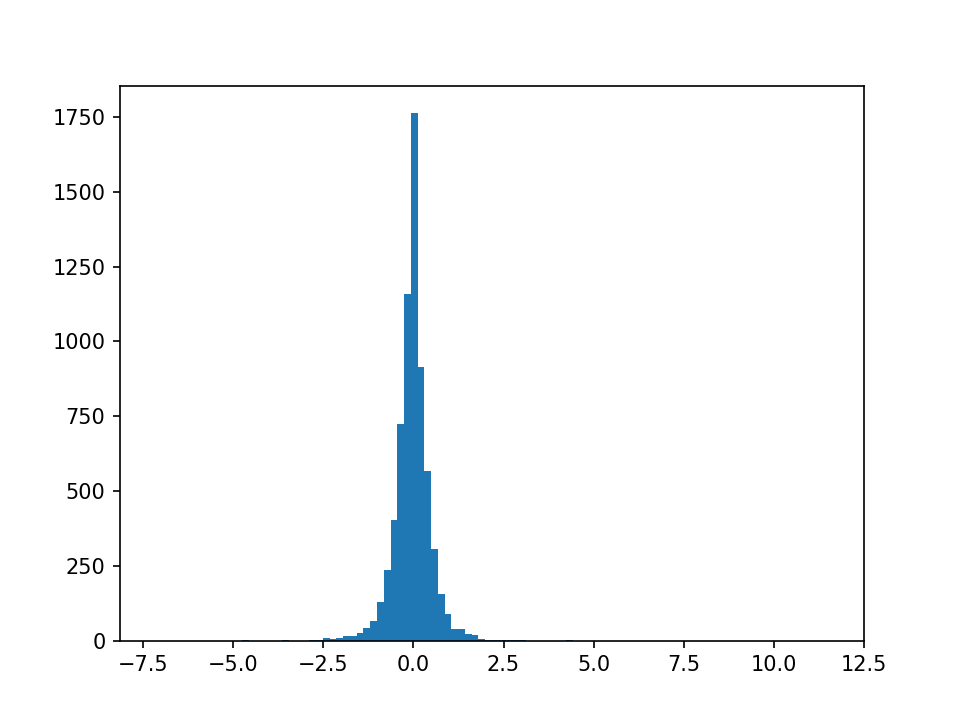

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   9.00000000e+00,   5.00000000e+00,
          8.00000000e+00,   1.50000000e+01,   1.60000000e+01,
          2.60000000e+01,   4.40000000e+01,   6.70000000e+01,
          1.28000000e+02,   2.38000000e+02,   4.04000000e+02,
          7.25000000e+02,   1.15900000e+03,   1.76400000e+03,
          9.15000000e+02,   5.68000000e+02,   3.06000000e+02,
          1.56000000e+02,   8.90000000e+01,   4.00000000e+01,
          4.00000000e+01,   2.20000000e+01,   1.90000000e+01,
        

In [7]:
plt.hist(gis1_rph1_data_fc['3d_gr-wt'],bins=100)

In [ ]:
#Per histogram a cutoff of 1 (log 2) seems to capture plenty of genes. 

In [149]:
rg_columns = ['log_g-wt','log_r-wt', 'log_gr-wt', 'PDS_g-wt', 'PDS_r-wt', 'PDS_gr-wt', '3d_r-wt','3d_gr-wt', '3d_g-wt']
for column in rg_columns: 
    kl_sc_PKA_data_gr[column+'_label'] = io_library.threshold_group_series(kl_sc_PKA_data_gr[column], act_threshold, inh_threshold )

In [147]:
#merge with my KL/SC data
kl_sc_PKA_data_gr = kl_sc_PKA_data.merge(gis1_rph1_data_fc, left_on = 'sc_genename', right_index=True, how = 'inner')

#Use cutoff to assign activated, inhibited, and repressed for gis1, rph1 and gis1rph1 for each condition
act_threshold = 1
inh_threshold = -1

rg_columns = ['log_g-wt','log_r-wt', 'log_gr-wt', 'PDS_g-wt', 'PDS_r-wt', 'PDS_gr-wt', '3d_r-wt','3d_gr-wt', '3d_g-wt']
for column in rg_columns: 
    kl_sc_PKA_data_gr[column+'_label'] = io_library.threshold_group_series(kl_sc_PKA_data_gr[column], act_threshold, inh_threshold )


('up', 'up', 'up')
('up', 'up', 'flat')
('up', 'up', 'down')
('up', 'flat', 'up')
('up', 'flat', 'flat')
('up', 'flat', 'down')
('up', 'down', 'up')
('up', 'down', 'flat')
('up', 'down', 'down')
('flat', 'up', 'up')
('flat', 'up', 'flat')
('flat', 'up', 'down')
('flat', 'flat', 'up')
('flat', 'flat', 'flat')
('flat', 'flat', 'down')
('flat', 'down', 'up')
('flat', 'down', 'flat')
('flat', 'down', 'down')
('down', 'up', 'up')
('down', 'up', 'flat')
('down', 'up', 'down')
('down', 'flat', 'up')
('down', 'flat', 'flat')
('down', 'flat', 'down')
('down', 'down', 'up')
('down', 'down', 'flat')
('down', 'down', 'down')
('up', 'up', 'up')
('up', 'up', 'flat')
('up', 'up', 'down')
('up', 'flat', 'up')
('up', 'flat', 'flat')
('up', 'flat', 'down')
('up', 'down', 'up')
('up', 'down', 'flat')
('up', 'down', 'down')
('flat', 'up', 'up')
('flat', 'up', 'flat')
('flat', 'up', 'down')
('flat', 'flat', 'up')
('flat', 'flat', 'flat')
('flat', 'flat', 'down')
('flat', 'down', 'up')
('flat', 'down', 'fla

In [175]:
#Make list of genes for each condition that have 
gr_sets = {}
conditions = ['log', 'PDS','3d']
strains = ['g','r','gr']
for condition in conditions:
    gr_sets_cond = {}
    exp_profiles = tuple(product(['up','flat','down'],['up','flat','down'],['up','flat','down']))
    for g_label, r_label, gr_label in exp_profiles:
        gr_sets_cond['g-'+g_label + '_r-'+r_label + '_gr-'+gr_label] = list(kl_sc_PKA_data_gr[(kl_sc_PKA_data_gr[condition + '_g-wt_label']==g_label) &
                                                                      (kl_sc_PKA_data_gr[condition + '_r-wt_label']==r_label) &
                                                                      (kl_sc_PKA_data_gr[condition + '_gr-wt_label']==gr_label)]['sc_genename'])
    gr_sets[condition] = gr_sets_cond

gr_sets
            


{'3d': {'g-down_r-down_gr-down': ['YDR308C'],
  'g-down_r-down_gr-flat': [],
  'g-down_r-down_gr-up': [],
  'g-down_r-flat_gr-down': ['YKR076W',
   'YDL218W',
   'YMR169C',
   'YKL107W',
   'YMR170C',
   'YGR052W',
   'YGR256W',
   'YBL075C',
   'YMR118C',
   'YDL085W',
   'YPL223C',
   'YDL223C',
   'YJL045W',
   'YDR096W',
   'YLR164W'],
  'g-down_r-flat_gr-flat': ['YBR280C',
   'YML128C',
   'YOR107W',
   'YER127W',
   'YDR256C',
   'YDR432W',
   'YOR283W',
   'YDR464W',
   'YHR085W',
   'YNL075W',
   'YDR167W',
   'YNL115C',
   'YOL010W',
   'YDR397C',
   'YDR465C',
   'YER030W',
   'YEL026W',
   'YLR109W',
   'YDL169C',
   'YKL009W',
   'YLR070C',
   'YNL110C',
   'YDR075W',
   'YER029C',
   'YLR284C',
   'YMR036C',
   'YIL057C',
   'YDL222C',
   'YMR175W',
   'YPR158W',
   'YNL009W',
   'YEL030W'],
  'g-down_r-flat_gr-up': ['YLR367W', 'YDR111C'],
  'g-down_r-up_gr-down': [],
  'g-down_r-up_gr-flat': ['YER002W', 'YBR212W'],
  'g-down_r-up_gr-up': ['YPR101W', 'YJL191W'],
  'g-flat_

In [176]:
#print out numbers for gr_sets
for condition in conditions: 
    print(condition)
    for key, item in gr_sets[condition].items():
        print(key + ': ' + str(len(item)))

log
g-up_r-up_gr-up: 9
g-up_r-up_gr-flat: 1
g-up_r-up_gr-down: 0
g-up_r-flat_gr-up: 2
g-up_r-flat_gr-flat: 14
g-up_r-flat_gr-down: 2
g-up_r-down_gr-up: 0
g-up_r-down_gr-flat: 0
g-up_r-down_gr-down: 0
g-flat_r-up_gr-up: 12
g-flat_r-up_gr-flat: 13
g-flat_r-up_gr-down: 0
g-flat_r-flat_gr-up: 52
g-flat_r-flat_gr-flat: 3562
g-flat_r-flat_gr-down: 12
g-flat_r-down_gr-up: 0
g-flat_r-down_gr-flat: 2
g-flat_r-down_gr-down: 1
g-down_r-up_gr-up: 0
g-down_r-up_gr-flat: 2
g-down_r-up_gr-down: 0
g-down_r-flat_gr-up: 2
g-down_r-flat_gr-flat: 37
g-down_r-flat_gr-down: 1
g-down_r-down_gr-up: 0
g-down_r-down_gr-flat: 1
g-down_r-down_gr-down: 0
PDS
g-up_r-up_gr-up: 2
g-up_r-up_gr-flat: 0
g-up_r-up_gr-down: 0
g-up_r-flat_gr-up: 16
g-up_r-flat_gr-flat: 34
g-up_r-flat_gr-down: 0
g-up_r-down_gr-up: 0
g-up_r-down_gr-flat: 0
g-up_r-down_gr-down: 0
g-flat_r-up_gr-up: 5
g-flat_r-up_gr-flat: 1
g-flat_r-up_gr-down: 0
g-flat_r-flat_gr-up: 114
g-flat_r-flat_gr-flat: 3421
g-flat_r-flat_gr-down: 83
g-flat_r-down_gr-up

In [178]:
kl_sc_PKA_data_gr.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'rlog_AS_noNMPP1_YPD_t40_mean_KL', 'rlog_AS_yesNMPP1_YPD_t40_mean_KL',
       'rlog_AS_noNMPP1_YPD_t40_var_KL', 'rlog_AS_yesNMPP1_YPD_t40_var_KL',
       'raw_AS_noNMPP1_YPD_t40_mean_KL', 'raw_AS_yesNMPP1_YPD_t40_mean_KL',
       'raw_AS_noNMPP1_YPD_t40_var_KL', 'raw_AS_yesNMPP1_YPD_t40_var_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'rlog_AS_noNMPP1_YPD_t40_mean_SC',
       'rlog_AS_yesNMPP1_YPD_t40_mean_SC', 'rlog_AS_noNMPP1_YPD_t40_var_SC',
       'rlog_AS_yesNMPP1_YPD_t40_var_SC', 'raw_AS_noNMPP1_YPD_t40_mean_SC',
       'raw_AS_yesNMPP1_YPD_t40_mean_SC', 'raw_AS_noNMPP1_YPD_t40_var_SC',
       'raw_AS_yesNMPP1_YPD_t40_var_SC', 'SC_common_name', 'log_g-wt',
       'log_r-wt', 'log_gr-wt', 'PDS_g-wt', 'PDS_r-wt', 'PDS_gr-wt', '3d_r-wt',
       '3d_gr-wt', '3d_g-wt', 'log_g-w

In [182]:
for condition in conditions:    # condition = 'log'

    #Plot kl v.s. sc with overlay from gis1 rph1 experiment

    hover_text = []
    for ind, row in kl_sc_PKA_data_gr.iterrows():
        hover_text.append(('{SC_common_name}<br>{gminwt}<br>{rminwt}<br>{grminwt}').format(
                                  SC_common_name=row['SC_common_name'],
                                  gminwt = row[condition + '_g-wt'], 
                                  rminwt = row[condition + '_r-wt'],
                                  grminwt = row[condition + '_gr-wt']))

    kl_sc_PKA_data_gr['hover_'+condition] = hover_text

    data = []

    for strain_phenotypes, genes in gr_sets[condition].items():
        kl_sc_PKA_data_gr_subset = kl_sc_PKA_data_gr[kl_sc_PKA_data_gr['sc_genename'].isin(genes)]

        trace = pygo.Scatter(
            x = kl_sc_PKA_data_gr_subset['log2FoldChange_KL'],
            y =  kl_sc_PKA_data_gr_subset['log2FoldChange_SC'],
            text = kl_sc_PKA_data_gr_subset['hover_'+condition],
            mode = 'markers',
            marker = {'opacity': 0.5},
            name = strain_phenotypes
        )

        data.append(trace)

    layout = pygo.Layout(
        xaxis= {
            #"range":[-2, 20],
            "title":'K.Lac LFC'
        },
        yaxis= {
            #"range":[-2, 20],
            "title":'S.Cer LFC'
        }
    )


    fig = pygo.Figure(data=data, layout = layout)
    py.iplot(fig, filename='rph1_gis1_projection_'+ condition)

In [166]:
g_label = 'up'
r_label = 'up'
gr_label = 'up'
list(kl_sc_PKA_data_gr[(kl_sc_PKA_data_gr['log_g-wt_label']==g_label) &
                  (kl_sc_PKA_data_gr['log_r-wt_label']==r_label) &
                  (kl_sc_PKA_data_gr['log_gr-wt_label']==gr_label)]['sc_genename'])

['YPR160W',
 'YPR127W',
 'YNL274C',
 'YOR052C',
 'YPL230W',
 'YOR185C',
 'YER062C',
 'YMR105C',
 'YEL039C']

<IPython.core.display.Javascript object>


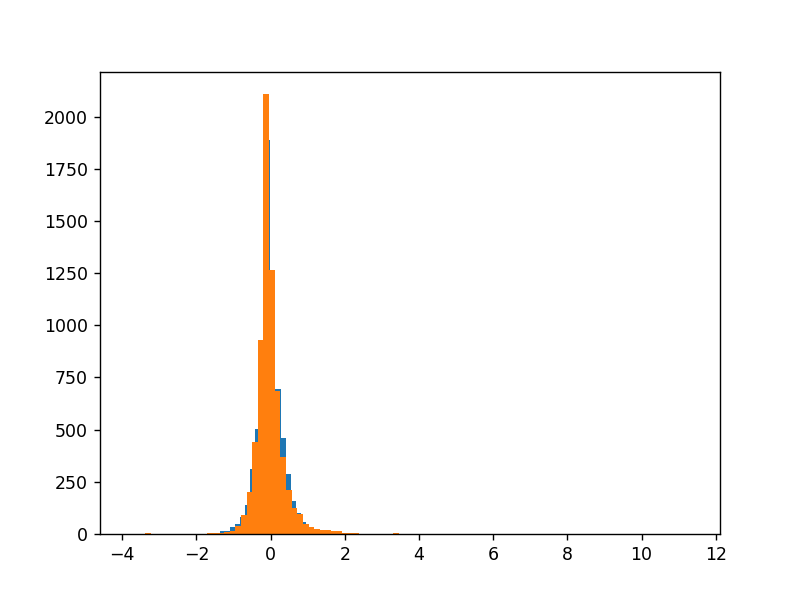

(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   6.00000000e+00,   5.00000000e+00,
          1.60000000e+01,   1.50000000e+01,   3.20000000e+01,
          4.80000000e+01,   8.30000000e+01,   1.40000000e+02,
          3.10000000e+02,   5.05000000e+02,   9.08000000e+02,
          1.88900000e+03,   1.02500000e+03,   6.93000000e+02,
          4.59000000e+02,   2.87000000e+02,   1.60000000e+02,
          1.01000000e+02,   5.60000000e+01,   3.40000000e+01,
          8.00000000e+00,   7.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [113]:
plt.hist(gis1_rph1_data_fc['log_g-wt'],bins=100)


In [20]:
# YJL136w-a lowercase is that a problem to link up with mine? 